In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/sr-press


In [2]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier
import matplotlib.pyplot as plt

In [3]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.components.utils import log_model, load_model
from express.visualization import plot_action
from express.utils import add_names

In [4]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fc1742f6700>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fc2376fcaf0>


In [5]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/test')


In [6]:
from express import features as fs
from express import labels as ls

all_features = [f.__name__ for f in fs.all_features]
all_labels = [f.__name__ for f in ls.all_labels]
print("Features:", all_features)
print("Labels:", all_labels)

Features: ['actiontype', 'actiontype_onehot', 'result', 'result_onehot', 'bodypart', 'bodypart_onehot', 'time', 'startlocation', 'relative_startlocation', 'endlocation', 'relative_endlocation', 'startpolar', 'endpolar', 'movement', 'team', 'time_delta', 'space_delta', 'goalscore', 'angle', 'under_pressure', 'packing_rate', 'ball_height_onehot', 'player_possession_time', 'speed', 'nb_opp_in_path', 'dist_opponent', 'defenders_in_3m_radius', 'closest_3_players', 'extract_all_players']
Labels: ['concede_shots', 'counterpress']


In [40]:
train_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "train"),
    xfns=["startlocation", "endlocation", "movement", "startpolar", "endpolar", "team", "time", "goalscore", "extract_all_players"],
    yfns=all_labels,#["counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=3
)

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=["startlocation", "endlocation", "movement", "startpolar", "endpolar", "team", "time", "goalscore", "extract_all_players"],
    yfns=["counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=3
)

In [55]:
nb_prev_actions_lst = ["0", "1", "2"] # current(0), previous(1), second_previous(2)
selected_features = ["startlocation", "endlocation", "movement", "startpolar", "endpolar", "team", "time", "goalscore", "extract_all_players"]
features = {}
label = ["counterpress"]

for xfn in train_dataset.xfns.items():
    key = xfn[0].__name__
    values = xfn[1]

    if key in selected_features:
        features[key] = [value for value in values if value[-1:] in nb_prev_actions_lst]

features

{'startlocation': ['start_x_a0',
  'start_y_a0',
  'start_x_a1',
  'start_y_a1',
  'start_x_a2',
  'start_y_a2'],
 'endlocation': ['end_x_a0',
  'end_y_a0',
  'end_x_a1',
  'end_y_a1',
  'end_x_a2',
  'end_y_a2'],
 'movement': ['dx_a0',
  'dy_a0',
  'movement_a0',
  'dx_a1',
  'dy_a1',
  'movement_a1',
  'dx_a2',
  'dy_a2',
  'movement_a2'],
 'startpolar': ['start_dist_to_goal_a0',
  'start_angle_to_goal_a0',
  'start_dist_to_goal_a1',
  'start_angle_to_goal_a1',
  'start_dist_to_goal_a2',
  'start_angle_to_goal_a2'],
 'endpolar': ['end_dist_to_goal_a0',
  'end_angle_to_goal_a0',
  'end_dist_to_goal_a1',
  'end_angle_to_goal_a1',
  'end_dist_to_goal_a2',
  'end_angle_to_goal_a2'],
 'team': ['team_1', 'team_2'],
 'time': ['period_id_a0',
  'time_seconds_a0',
  'time_seconds_overall_a0',
  'period_id_a1',
  'time_seconds_a1',
  'time_seconds_overall_a1',
  'period_id_a2',
  'time_seconds_a2',
  'time_seconds_overall_a2'],
 'goalscore': [],
 'extract_all_players': ['teammate_1_x_a0',
  't

In [48]:
xgb=XGBClassifier(
    objective="binary:logistic", 
    eval_metric='logloss' #"auc"
    # you probably want to do some hyperparameter tuning here to get a good model
)
xgb=XGBClassifier(
    n_estimators=400, max_depth=5, n_jobs=-1, verbosity=0, eval_metric="logloss"
)

model = press.XGBoostComponent(
    model = xgb,
    features = features,
    label = label
)

model.train(dataset_train)

2024/11/04 17:19:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/11/04 17:19:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '48685648559c4c4ebe9cf3eb92b17aa1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-logloss:0.55689
[1]	validation_0-logloss:0.48001
[2]	validation_0-logloss:0.43261
[3]	validation_0-logloss:0.40068
[4]	validation_0-logloss:0.38060
[5]	validation_0-logloss:0.36653
[6]	validation_0-logloss:0.35798
[7]	validation_0-logloss:0.34957
[8]	validation_0-logloss:0.34304
[9]	validation_0-logloss:0.33881
[10]	validation_0-logloss:0.33646
[11]	validation_0-logloss:0.33292
[12]	validation_0-logloss:0.33005
[13]	validation_0-logloss:0.32863
[14]	validation_0-logloss:0.32505
[15]	validation_0-logloss:0.32319
[16]	validation_0-logloss:0.32204
[17]	validation_0-logloss:0.32099
[18]	validation_0-logloss:0.31913
[19]	validation_0-logloss:0.31810
[20]	validation_0-logloss:0.31690
[21]	validation_0-logloss:0.31632
[22]	validation_0-logloss:0.31565
[23]	validation_0-logloss:0.31478
[24]	validation_0-logloss:0.31414
[25]	validation_0-logloss:0.31294
[26]	validation_0-logloss:0.31214
[27]	validation_0-logloss:0.31095
[28]	validation_0-logloss:0.30986
[29]	validation_0-loglos

In [49]:
model.test(dataset_train)

{'precision': 0.9600367478180983,
 'recall': 0.9081691772885284,
 'f1': 0.9333829549683662,
 'log_loss': 0.08850768262816434,
 'brier': 0.020765969592580088,
 'roc_auc': 0.9873398770833292}

In [50]:
model.test(dataset_test)

{'precision': 0.7319587628865979,
 'recall': 0.5463365674138508,
 'f1': 0.6256704980842912,
 'log_loss': 0.3693847077481547,
 'brier': 0.10145993538534626,
 'roc_auc': 0.8948420660092941}

In [57]:
est = SymbolicClassifier(
    population_size=3000,  # 인구 집단 크기 증가
    generations=100,  # 더 많은 세대
    tournament_size=30,  # 더 큰 토너먼트 크기
    stopping_criteria=0.2,  # 조기 중단 기준
    const_range=(-1, 1),  # 상수 범위 제한
    parsimony_coefficient=1e-3,  # 과적합 방지, 낮은 값으로 복잡한 수식을 억제
    p_crossover=0.7,  # 교차 확률 증가
    p_subtree_mutation=0.1,  # 서브트리 돌연변이
    p_hoist_mutation=0.05,  # 호이스트 돌연변이
    p_point_mutation=0.1,  # 포인트 돌연변이
    function_set=['add', 'mul', 'sub', 'div', 'abs', 'sqrt', 'sin', 'tan', 'cos', 'max', 'min'],  # 더 복잡한 함수 추가
    verbose=1,  # 진행 상황 출력
    feature_names=[f for f_set in features.values() for f in f_set],  # 피처 이름
    random_state=1,  # 재현성
    n_jobs=-1,  # 병렬 처리
    init_depth= (2,6),
    max_samples=0.9
)

model = press.SymbolicComponent(
    model=est,
    features=features,
    label=label
)
model.train(dataset_train)

ValueError: Input X contains NaN.
SymbolicClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [12]:
model.test(dataset_train)

{'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'log_loss': 1.8014919044262658,
 'brier': 0.18584830515193107,
 'roc_auc': 0.6079351771129652}

In [13]:
model.test(dataset_test)

{'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'log_loss': 2.0571228757219546,
 'brier': 0.2032149556342932,
 'roc_auc': 0.6139417115906391}

### XGBoost feature importances

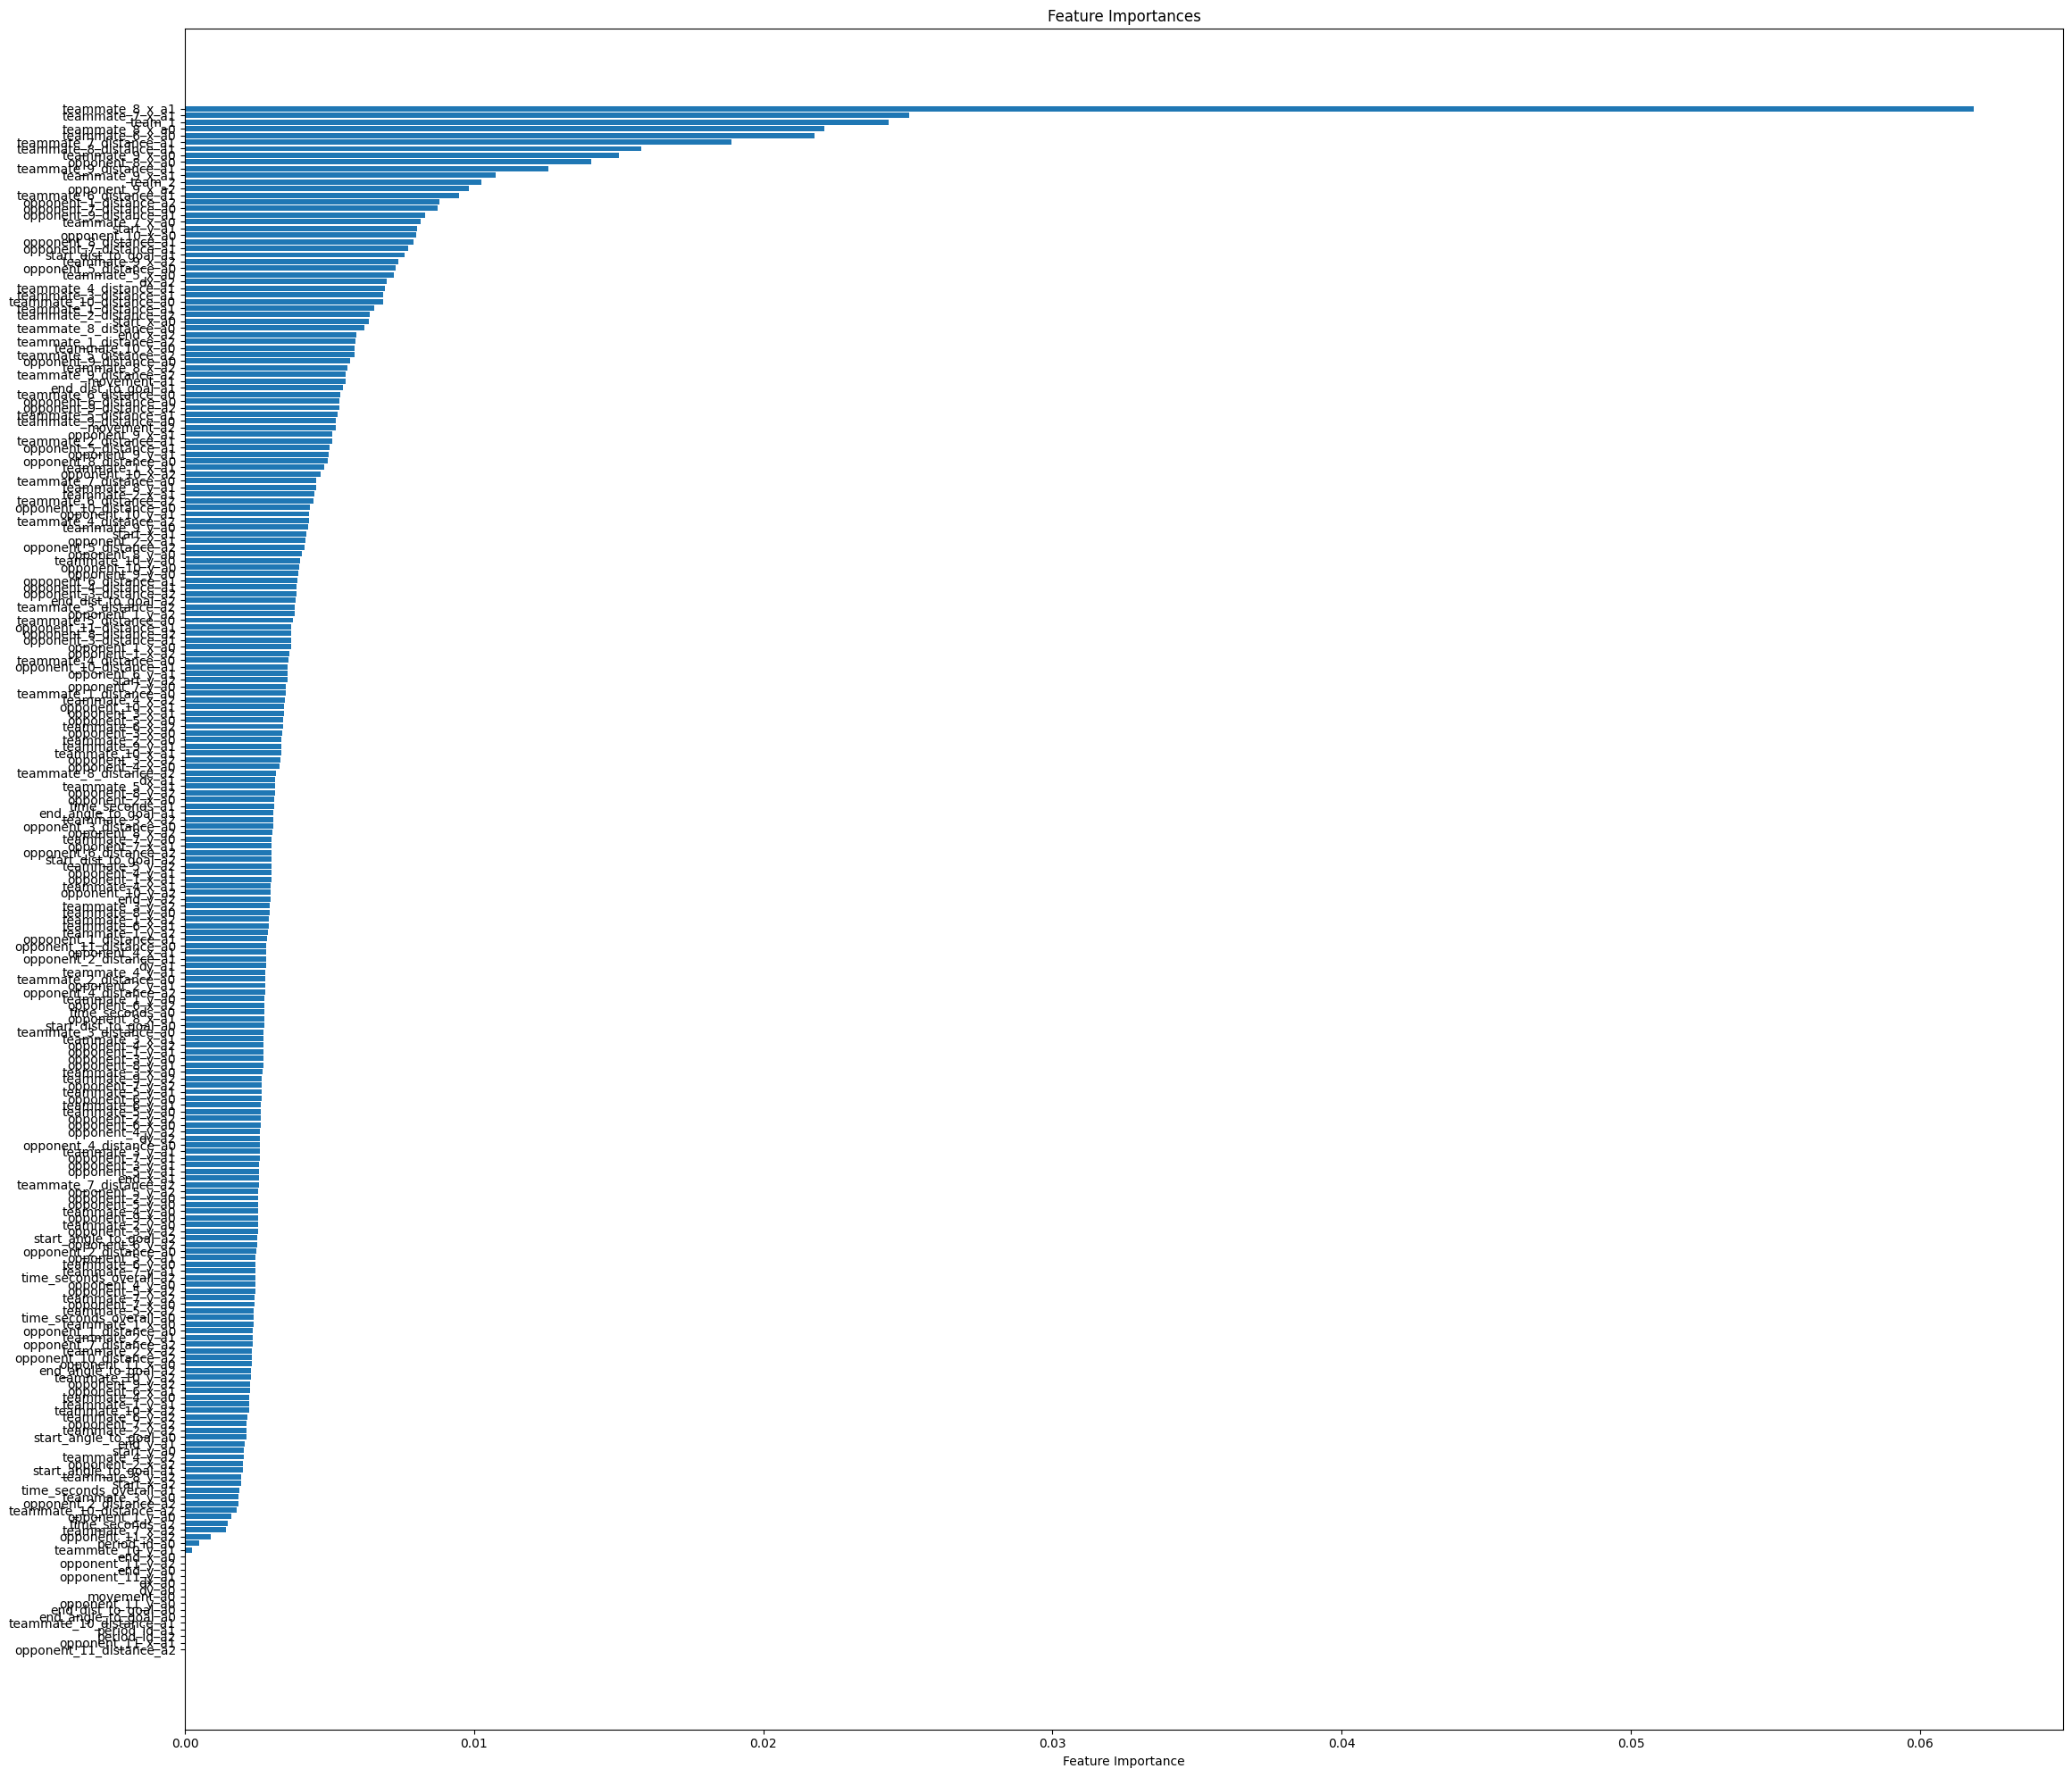

In [51]:
features = [col for _, cols in model.features.items() for col in cols]
importances = model.model.feature_importances_

# 컬럼 수에 따라 가변적인 시각화 크기 설정
num_features = len(features)
plt.figure(figsize=(max(10, num_features * 0.1), 20))  # 특징 수에 따라 증가


indices = np.argsort(importances) 
plt.barh(range(num_features), importances[indices], align='center')
plt.yticks(range(num_features), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')

plt.tight_layout()
plt.show()

In [ ]:
game_id = 3895302

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895302,0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,1,3.417,176,34870,52.0625,33.660,53.8125,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 12299, 'name': '...",None,0,None,pass,success,foot_right
1,3895302,1,77809242-1460-4395-8779-94a0cfc275b1,1,3.870,176,12299,53.8125,34.340,53.8125,...,176.0,From Kick Off,0,"{'carry': {'end_location': [59.0, 40.6]}}",None,0,None,dribble,success,foot
2,3895302,2,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,1,4.732,176,12299,53.8125,34.085,74.7250,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 31100, 'name': '...","[[90.44126933110154, 68.0], [67.695055809645, ...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3895302,3,cf9088bc-7e59-4d57-8ac5-31658da858bb,1,6.728,176,31100,74.7250,36.295,74.7250,...,176.0,From Kick Off,0,"{'carry': {'end_location': [35.1, 43.7]}}","[[94.70003623525969, 68.0], [70.82236198763701...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
4,3895302,4,4464cb75-f45f-4508-8444-2560d1625d06,1,7.622,176,31100,74.7250,36.720,76.3875,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 51769, 'name': '...","[[96.23592025888192, 68.0], [71.95638033011264...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right


### Visualization

Skip action due to missing freeze frame


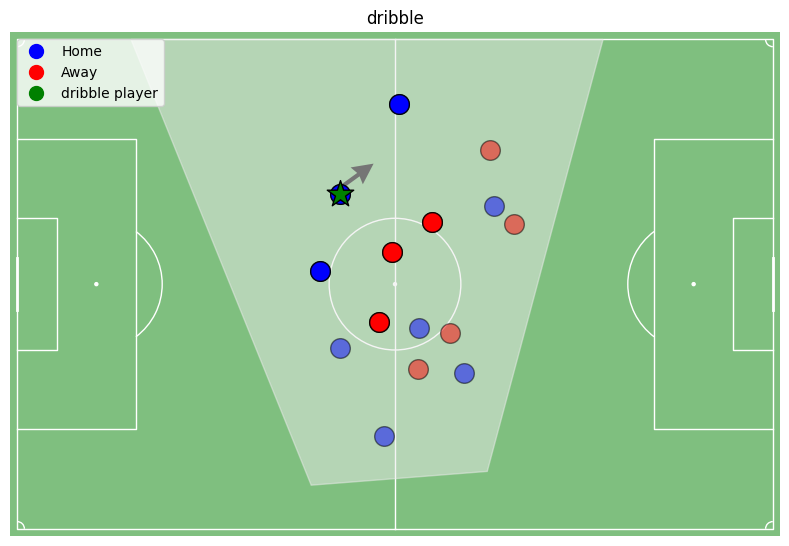

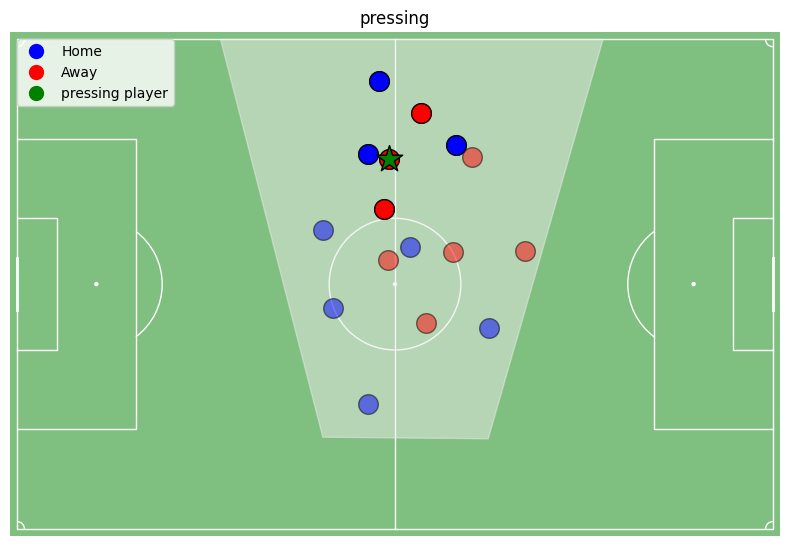

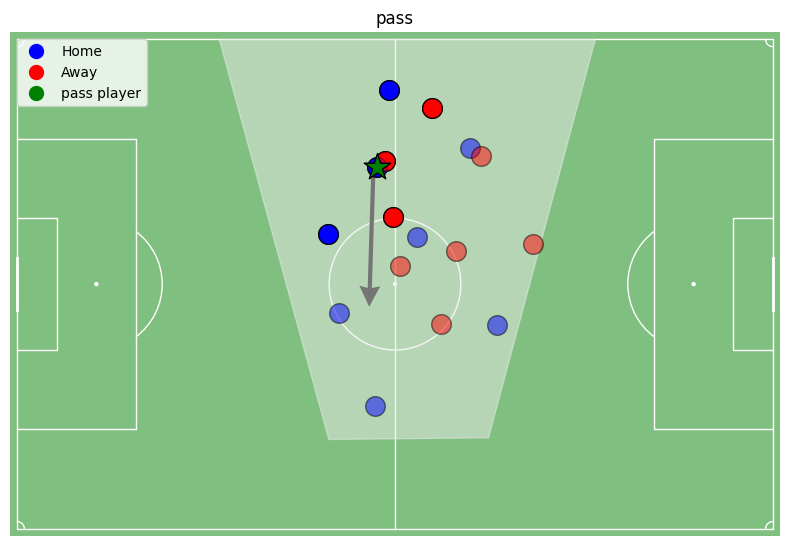

In [ ]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)